In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
from tensorflow.keras.datasets import mnist

In [7]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### define networks

In [8]:
dims = (28,28,1)
n_components = 64

In [9]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

In [10]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=7 * 7 * 256, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    )
])

In [11]:
input_img = tf.keras.Input(dims)
output_img = decoder(encoder(input_img))
autoencoder = tf.keras.Model(input_img, output_img)

In [12]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
X_train = X_train.reshape([len(X_train)] + list(dims))
history = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                #validation_data=(X_valid, X_valid)
                         )

Epoch 1/50
196/196 [==============================] - 7s 35ms/step - loss: 0.1992
Epoch 2/50
196/196 [==============================] - 7s 36ms/step - loss: 0.0926
Epoch 3/50
196/196 [==============================] - 9s 46ms/step - loss: 0.0801
Epoch 4/50
196/196 [==============================] - 10s 52ms/step - loss: 0.0757
Epoch 5/50
196/196 [==============================] - 9s 46ms/step - loss: 0.0733
Epoch 6/50
196/196 [==============================] - 10s 52ms/step - loss: 0.0716
Epoch 7/50
196/196 [==============================] - 11s 54ms/step - loss: 0.0706
Epoch 8/50
196/196 [==============================] - 11s 54ms/step - loss: 0.0697
Epoch 9/50
196/196 [==============================] - 10s 53ms/step - loss: 0.0688
Epoch 10/50
196/196 [==============================] - 9s 45ms/step - loss: 0.0683
Epoch 11/50
196/196 [==============================] - 9s 44ms/step - loss: 0.0679
Epoch 12/50
196/196 [==============================] - 9s 44ms/step - loss: 0.0675
Epoch 13

In [14]:
z = encoder.predict(X_train)

### Plot model output

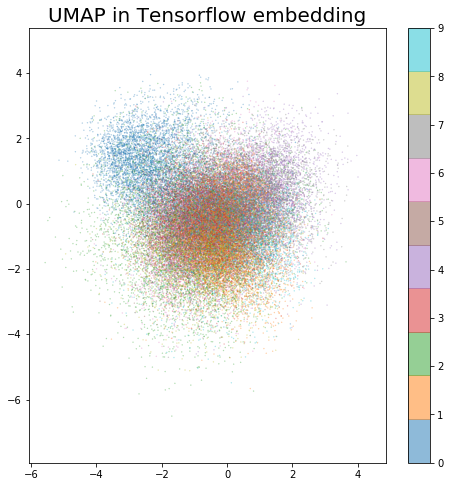

In [15]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [16]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

### Save output

In [17]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [18]:
output_dir = MODEL_DIR/'projections'/ 'mnist' / '64' / 'ae_only'
ensure_dir(output_dir)

In [19]:
encoder.save(output_dir / 'encoder')

W0821 22:12:54.740079 140073181824832 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
W0821 22:12:54.754896 140073181824832 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
I0821 22:12:55.132215 140073181824832 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/64/ae_o

In [20]:
decoder.save(output_dir / 'encoder')

I0821 22:12:57.084693 140073181824832 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/64/ae_only/encoder/assets


In [21]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [22]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [23]:
X_test.shape

(10000, 784)

In [24]:
z_test = encoder.predict(X_test.reshape((len(X_test), 28,28,1)))

#### silhouette

In [25]:
from tfumap.silhouette import silhouette_score_block

In [26]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.06533412347003248

In [27]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.07225767073593586

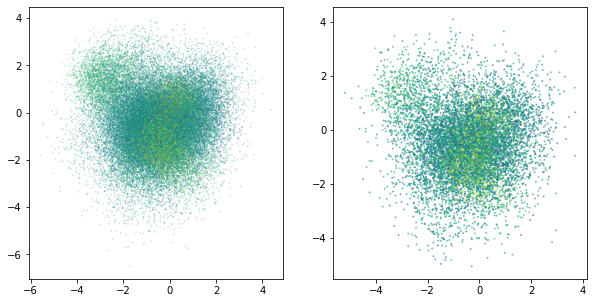

In [28]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.9758

In [31]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.9748

#### Trustworthiness

In [32]:
from sklearn.manifold import trustworthiness

In [33]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [34]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [35]:
tw, tw_test

(0.9997128282626101, 0.9997212429943955)

### Save output metrics

In [36]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [37]:
dataset = 'mnist'

#### train

In [38]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'ae_only', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,mnist,ae_only,64,0.999713,0.065334,"[-0.009628635784313793, 0.1924411096825642, 0...."


In [39]:
save_loc = DATA_DIR / 'projection_metrics' /  'ae_only' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### test

In [40]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'ae_only', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,mnist,ae_only,64,0.999721,0.072258,"[0.18297630683507454, 0.0072480099941307765, 0..."


In [41]:
save_loc = DATA_DIR / 'projection_metrics' / 'ae' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [42]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['ae_only', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,ae_only,64,mnist,0.9748,0.9758


In [43]:
save_loc = DATA_DIR / 'knn_classifier' / 'ae_only' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Reconstruction

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [45]:
X_recon = decoder.predict(encoder.predict(X_test.reshape((len(X_test), 28, 28, 1))))
X_real = X_test.reshape((len(X_test), 28, 28, 1))

In [46]:
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [47]:
reconstruction_acc_df = pd.DataFrame(
    columns=["method_", "dimensions", "dataset", "MSE", "MAE", "MedAE", "R2"]
)

In [48]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['ae_only', n_components, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,ae_only,64,mnist,0.001617,0.011262,0.000959,-13.957888


In [49]:
save_loc = DATA_DIR / 'reconstruction_acc' / 'ae_only' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
reconstruction_acc_df.to_pickle(save_loc)

In [54]:
save_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/reconstruction_acc/ae_only/64/mnist.pickle')

### Compute clustering quality

In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [51]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    if save_loc.exists() and save_loc.is_file():
        
        cluster_df = pd.read_pickle(save_loc)
        return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                y, clustered_y
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [52]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, 'ae_only', z, Y_train, n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,mnist,ae_only,"[[-0.48847306, -1.6861641, -0.48567685, 0.1650...","[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, ...",64


In [53]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/ae_only_64_mnist.pickle


,dataset,class_,dim,silhouette,homogeneity,completeness,v_measure,init_,n_clusters,model
0,mnist,ae_only,64,0.079812,0.258919,0.374021,0.306004,0,5,"KMeans(n_clusters=5, random_state=0)"
1,mnist,ae_only,64,0.079957,0.258527,0.373589,0.305586,1,5,"KMeans(n_clusters=5, random_state=1)"
2,mnist,ae_only,64,0.079574,0.259212,0.374431,0.306346,2,5,"KMeans(n_clusters=5, random_state=2)"
3,mnist,ae_only,64,0.079871,0.258504,0.373500,0.305540,3,5,"KMeans(n_clusters=5, random_state=3)"
4,mnist,ae_only,64,0.079794,0.258934,0.374045,0.306023,4,5,"KMeans(n_clusters=5, random_state=4)"
5,mnist,ae_only,64,0.092796,0.354338,0.459230,0.400022,0,6,"KMeans(n_clusters=6, random_state=0)"
6,mnist,ae_only,64,0.092622,0.353017,0.457412,0.398491,1,6,"KMeans(n_clusters=6, random_state=1)"
7,mnist,ae_only,64,0.092702,0.353836,0.458472,0.399415,2,6,"KMeans(n_clusters=6, random_state=2)"
8,mnist,ae_only,64,0.092796,0.354276,0.459153,0.399954,3,6,"KMeans(n_clusters=6, random_state=3)"
9,mnist,ae_only,64,0.092803,0.354357,0.459269,0.400049,4,6,"KMeans(n_clusters=6, random_state=4)"
